In [8]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [9]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = 'D:\Documents\landscape\landscape Images\color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '3000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = 'D:\Documents\landscape\landscape Images\gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '3000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

 42%|████████████████████████████████▊                                             | 3000/7129 [00:41<00:57, 71.80it/s]


In [10]:
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

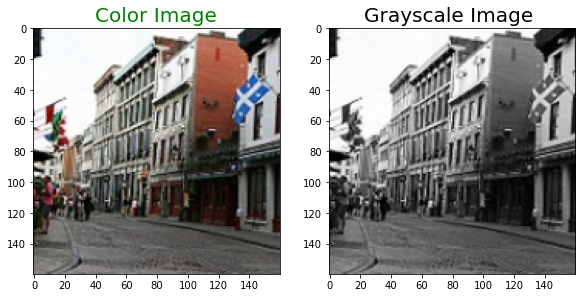

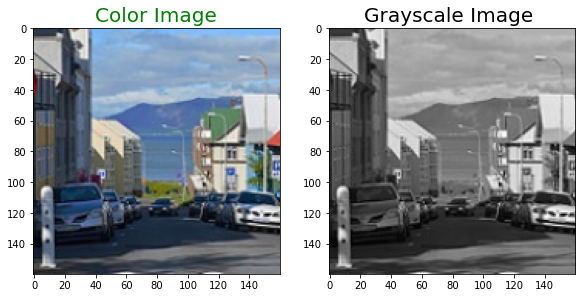

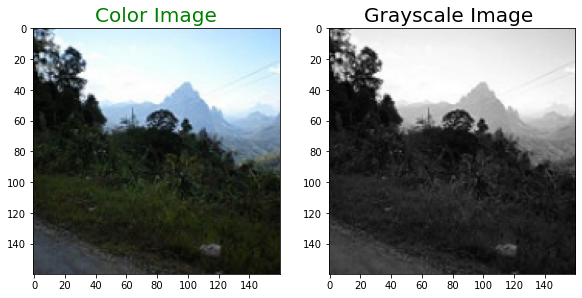

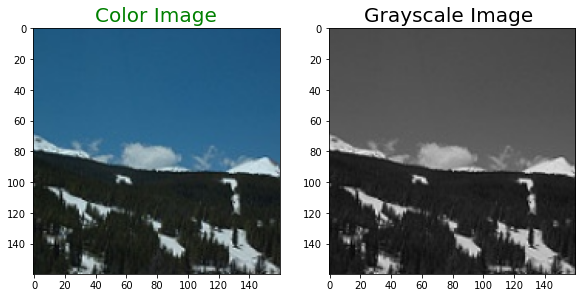

In [11]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

In [12]:
train_gray_image = gray_img[:2500]
train_color_image = color_img[:2500]

test_gray_image = gray_img[2500:]
test_color_image = color_img[2500:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (2500, 160, 160, 3)
Test color image shape (500, 160, 160, 3)


In [13]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [14]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [15]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 80, 80, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 40, 40, 128)  147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 20, 20, 256)  296192      ['sequential_1[0][0]']       

In [16]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs = 5,batch_size = 10,verbose = 1)

Epoch 1/5
250/250 [==============================] - 201s 776ms/step - loss: 0.0613 - acc: 0.4198
Epoch 2/5
250/250 [==============================] - 195s 779ms/step - loss: 0.0514 - acc: 0.4662
Epoch 3/5
250/250 [==============================] - 194s 776ms/step - loss: 0.0488 - acc: 0.4782
Epoch 4/5
250/250 [==============================] - 195s 779ms/step - loss: 0.0479 - acc: 0.4805
Epoch 5/5
250/250 [==============================] - 196s 783ms/step - loss: 0.0467 - acc: 0.4913


In [17]:
model.evaluate(test_gray_image,test_color_image)

16/16 [==============================] - 14s 842ms/step - loss: 0.0588 - acc: 0.5360


[0.05883709341287613, 0.5360077619552612]

1/1 [==============================] - 0s 265ms/step


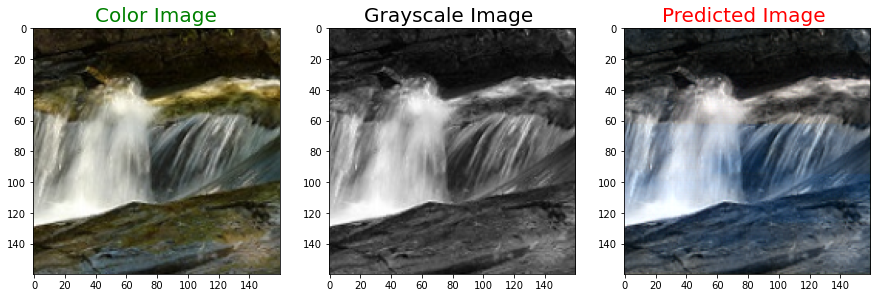

1/1 [==============================] - 0s 69ms/step


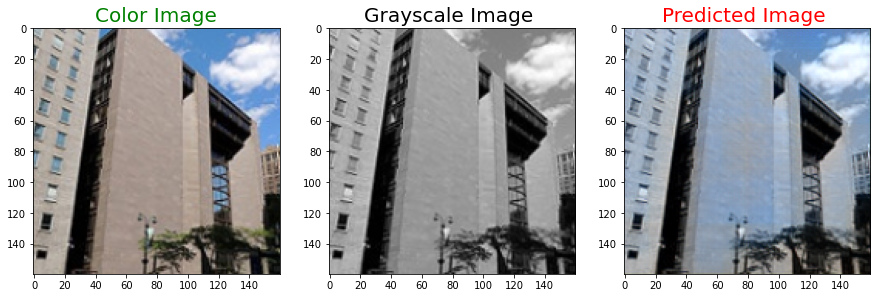

1/1 [==============================] - 0s 65ms/step


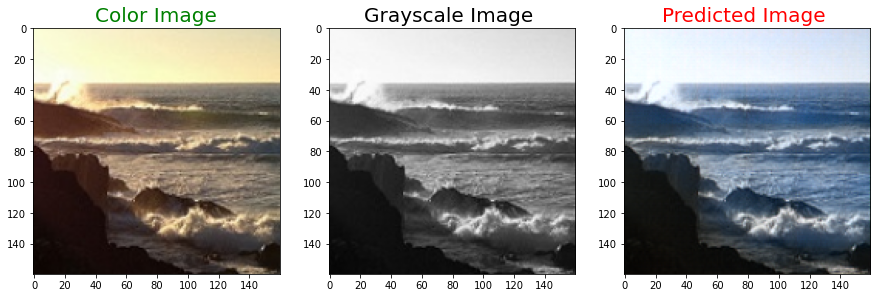

1/1 [==============================] - 0s 63ms/step


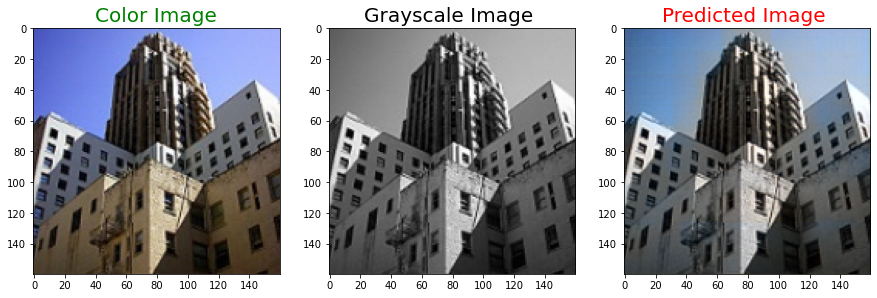

1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 65ms/step


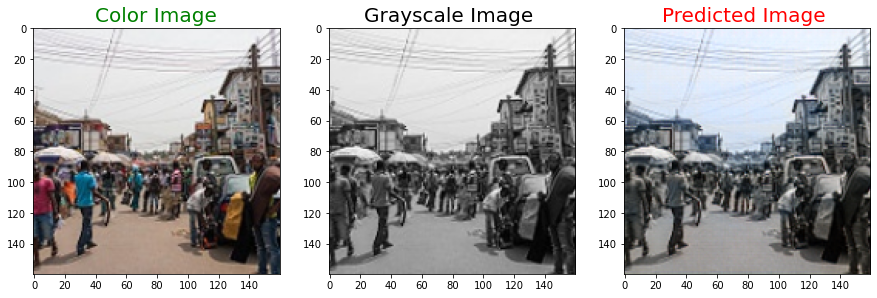

1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 81ms/step


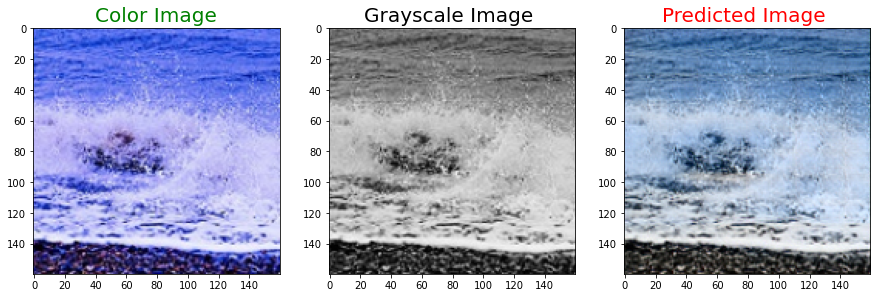

In [18]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(50,58):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)